# Evaluation Metrics Homework

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Data preparation

Data is available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv).

In [3]:
df = pd.read_csv('../data/CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Formatting columns:

In [4]:
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers, we need to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

Preparing the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Removing clients with unknown default status:

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable:

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

### 2. Answering the questions

What are the categorical variables? What are the numerical ones?

In [22]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [36]:
categorical_variables = list(df.columns[df.dtypes == 'object'])
numerical_variables = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

print(categorical_variables)
print(numerical_variables)

['home', 'marital', 'records', 'job']
['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['default'].values
y_val = df_val['default'].values
y_test = df_test['default'].values

del df_train['default']
del df_val['default']
del df_test['default']

In [25]:
len(df_train), len(df_test), len(df_val)

(2672, 891, 891)

#### Q1. Evaluate feautre importance using ROC AUC

In [30]:
from sklearn.metrics import roc_auc_score

In [37]:
for column in numerical_variables:
    auc = roc_auc_score(y_train, df_train[column])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[column])

    print(f'{column}: {auc}')

seniority: 0.7093778624491943
time: 0.5608662489595051
age: 0.5732933272499939
expenses: 0.5009184217217011
income: 0.682006666132633
assets: 0.6486042567122802
debt: 0.5047829675783548
amount: 0.5910773431595518
price: 0.5043329862114843


`seniority` is the most important feature.

Training the model:

In [40]:
columns_used = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [41]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns_used].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

#### Q2. What is the model's AUC on the validation dataset? 

In [42]:
val_dict = df_val[columns_used].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [45]:
auc = roc_auc_score(y_val, y_pred)
print(f'The model AUC is: {round(auc, 3)}')

The model AUC is: 0.811


#### Q3. Precision and recall

Computing precision and recall for a range of different threshold values:

In [58]:
thresholds = np.linspace(0, 1, 101)
results = []

for threshold in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    predicted_pos = (y_pred >= threshold)
    predicted_neg = (y_pred < threshold)

    tp = (predicted_pos & actual_pos).sum()
    tn = (predicted_neg & actual_neg).sum()

    fp = (predicted_pos & actual_neg).sum()
    fn = (predicted_neg & actual_pos).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    results.append([threshold, precision, recall])

In [62]:
df_results = pd.DataFrame(results, columns=['threshold', 'precision', 'recall'])

<AxesSubplot:xlabel='threshold'>

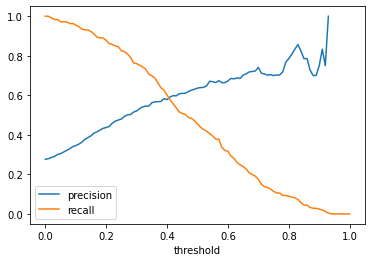

In [68]:
df_results.plot(x='threshold', y=['precision', 'recall'])

The threshold value where the intesection of precision and recall occurs is around `0.4`.  